## Attempt at creating isochrones maps for LA Chinatown major commercial properties
#### Author: Jiaqi Li

In this assignment, I will try to create an isochrones map that centers around LA Chinatown Central Plaza, which has been the center for daily life for Chinatown residents over the past decades. I will then layer this walkshed map with the previous residential unit density map, to find out what is the unit density of the residential buildings that fall into a walkshed of 5/10/15 minute from LA Chinatown Central Plaza. 

The purpose of this assignment is to investigate the proximity between recently built multi-family residential buildings and the neighborhood center in 2021. If this might be a valuable direction, we will create a loop for the commercial type and the residential ones in previous years, to track changes of multi-family unit builidings and their proximity to the neighborhood center.

First, we import the relevant libraries.

In [1]:
# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

# for interactive webmaps
import folium

Next, I will insert the latlon of LA Chinatown Central Plaza, and configure the network types, trip times, and estimate the walking speed to be 75 meters per minute.

I will also estimate if it takes reasonable time to run the cells.

In [2]:
latlon = [34.065363419370186, -118.23751588912273]
network_type = 'walk'
trip_times = [5, 10, 15]
meters_per_minute = 75

In [3]:
%%time
# download the street network
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

CPU times: user 5.08 s, sys: 119 ms, total: 5.2 s
Wall time: 5.22 s


Now I will plot to see if this looks right, and try project this data to Web Mercator.

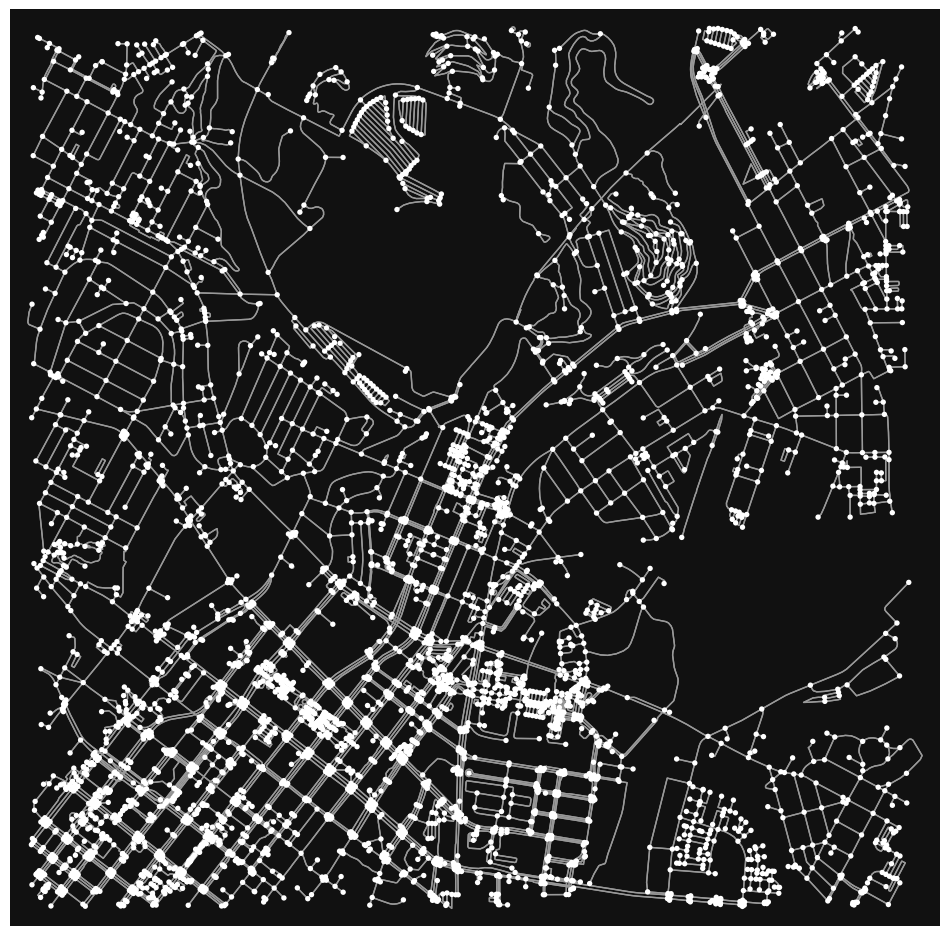

In [4]:
fig, ax = ox.plot_graph(G,figsize=(12,12))

In [5]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

#### Cconvert nodes and edges to geodataframes

I will also get some basic info of this dataframe before plotting it.

In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [7]:
gdf_nodes.sample(3)

y             x  street_count         lon        lat  \
osmid                                                                         
9254917570  4.035826e+06 -1.316430e+07             3 -118.256924  34.052297   
269607282   4.035209e+06 -1.316106e+07             4 -118.227776  34.047699   
6208583555  4.036185e+06 -1.316166e+07             3 -118.233216  34.054969   

                    highway                           geometry  
osmid                                                           
9254917570              NaN  POINT (-13164300.551 4035826.412)  
269607282   traffic_signals  POINT (-13161055.777 4035208.663)  
6208583555              NaN  POINT (-13161661.444 4036185.437)

In [8]:
gdf_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4441 entries, 14966389 to 10307367516
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             4441 non-null   float64 
 1   x             4441 non-null   float64 
 2   street_count  4441 non-null   int64   
 3   lon           4441 non-null   float64 
 4   lat           4441 non-null   float64 
 5   highway       781 non-null    object  
 6   geometry      4441 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 277.6+ KB


<AxesSubplot: >

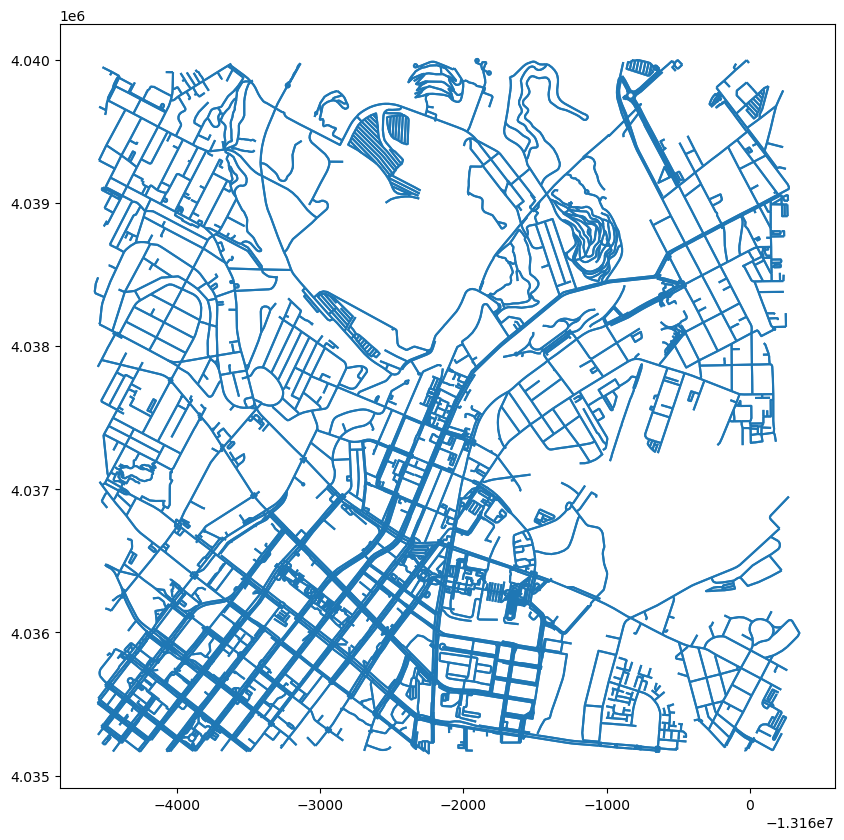

In [9]:
gdf_edges.plot(figsize=(10,10))

I will use the road info under the column 'highway' to estimate the potential roads on can take to walk.

In [10]:
gdf_edges['highway'].value_counts()

footway                          4860
service                          2744
residential                      1326
secondary                        1202
primary                          1012
tertiary                          570
unclassified                      272
[steps, footway]                  268
path                              158
track                             152
steps                             128
primary_link                       64
pedestrian                         62
[residential, service]             22
secondary_link                     14
[service, unclassified]            10
[pedestrian, footway]               6
[service, footway]                  6
[path, steps]                       6
[primary, secondary]                6
[residential, footway]              6
[residential, unclassified]         4
razed                               4
[pedestrian, service]               4
[residential, steps]                4
[service, steps, footway]           4
[pedestrian,

For this assignment, we will use the centroid of the streetnetwork.

In [21]:
# get the bounding box coordinates
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-13164555.105606502
4035165.4423256824
-13159727.791547993
4039996.140488583


In [22]:
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-13162141.448577248
4037580.7914071325


In [23]:
# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 5322526879


In [24]:
# use osmnx's distance.nearest_nodes command to get the id for the nearest node
center_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 5322526879


In [25]:
# what is this record?
gdf_nodes.loc[[center_node]]

y             x  street_count        lon       lat  \
osmid                                                                       
5322526879  4.037591e+06 -1.316215e+07             1 -118.23762  34.06543   

           highway                           geometry  
osmid                                                  
5322526879     NaN  POINT (-13162151.696 4037590.997)

We will see if the center node is in the center.

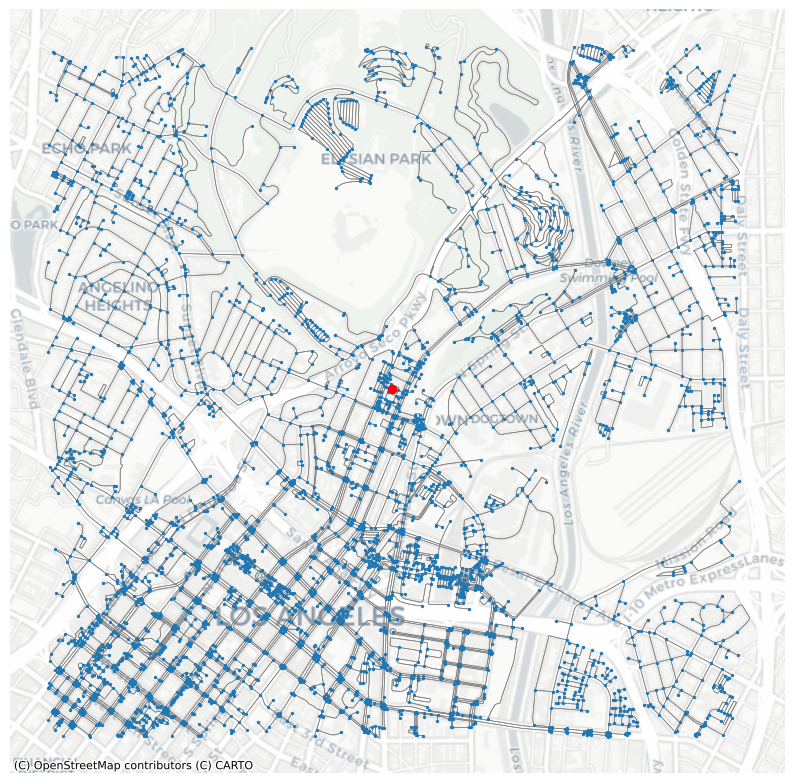

In [26]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

I would like to create the nuew column that calculates the time it takes to travel the edge.

In [27]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [29]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(2)

osmid  \
u          v          key                                                    
122663808  16941223   0                                          161707977   
9464527581 9071101774 0    [980634762, 1026531908, 1026531909, 1026531910]   

                                name      highway   length  walk_time  
u          v          key                                              
122663808  16941223   0    Avenue 20  residential  182.395   2.431933  
9464527581 9071101774 0          NaN      footway   99.474   1.326320

In [30]:
# choose a colormap
cmap = 'PuBuGn'

In the following codes, we will assign a color hex code for each trip time isochrone. Reverse the order to map the outside nodes first, loop through each trip time. We keep the uncovered area in grey.

In [31]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#fff7fb', '#66a9cf', '#014636']


In [32]:
# list of "zipped" time/colors
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#fff7fb'), (10, '#66a9cf'), (15, '#014636')]

In [33]:
# loop through the list of time/colors
for time,color in list(time_color):
    print('The color for '+str(time)+' minutes is ' + color)

The color for 5 minutes is #fff7fb
The color for 10 minutes is #66a9cf
The color for 15 minutes is #014636


In [34]:
time_color.reverse()
time_color

[(15, '#014636'), (10, '#66a9cf'), (5, '#fff7fb')]

In [36]:
# loop through each trip time and associated color
for time, color in list(time_color):

    subgraph = nx.ego_graph(G, center_node, radius=time,distance='time')

    print(str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
   
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

315 nodes within 15 minutes #014636
124 nodes within 10 minutes #66a9cf
29 nodes within 5 minutes #fff7fb


In [37]:
# spot check
gdf_nodes.sample(5)

y             x  street_count         lon        lat  \
osmid                                                                         
6787549599  4.037464e+06 -1.316218e+07             1 -118.237857  34.064484   
8657339826  4.036206e+06 -1.316385e+07             3 -118.252863  34.055119   
4873005719  4.037477e+06 -1.316342e+07             3 -118.248971  34.064579   
9674782289  4.035663e+06 -1.316247e+07             3 -118.240476  34.051082   
72928416    4.039729e+06 -1.316089e+07             3 -118.226253  34.081339   

           highway                           geometry  time    color  
osmid                                                                 
6787549599     NaN  POINT (-13162178.023 4037463.996)  10.0  #66a9cf  
8657339826     NaN  POINT (-13163848.472 4036205.591)   NaN      NaN  
4873005719     NaN  POINT (-13163415.216 4037476.667)   NaN      NaN  
9674782289     NaN  POINT (-13162469.535 4035663.155)   NaN      NaN  
72928416       NaN  POINT (-13160886.271 4039729.035)   NaN      NaN

In [38]:
# color the uncovered area
gdf_nodes['color'].fillna('#cccccc', inplace=True)

Cool. Now I will map the nodes again, but they should appear in different colors since they fall into different trip time frame.

<AxesSubplot: >

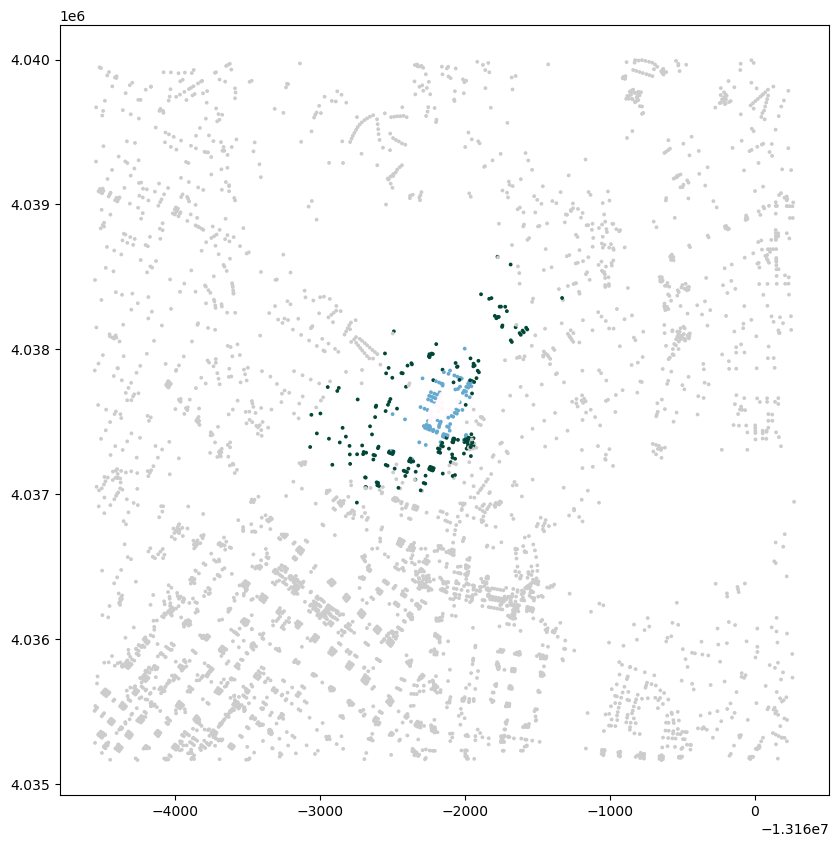

In [40]:
# map it
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

### Create the polygon for each trip time frame

In [43]:
# put the 5 minute nodes in a variable
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

<AxesSubplot: >

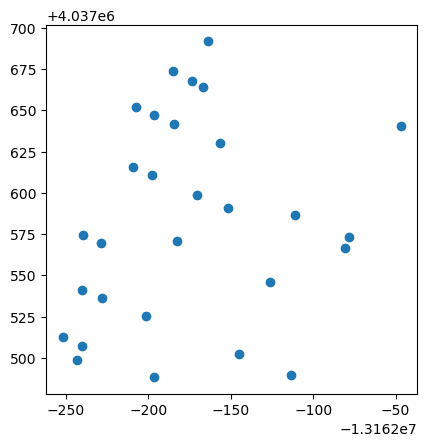

In [44]:
# plot it
gdf_5.plot()

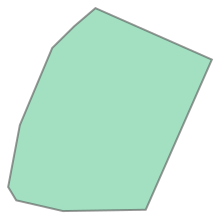

In [46]:
# combine points and create a convex hull polygon
gdf_5.unary_union.convex_hull

Now we need to dissove these nodes to create different boundaries for each trip time frame.

In [48]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

geometry             y  \
time                                                                    
5.0   MULTIPOINT (-13162251.482 4037512.331, -131622...  4.037640e+06   
10.0  MULTIPOINT (-13162504.244 4037299.330, -131624...  4.037403e+06   
15.0  MULTIPOINT (-13163067.309 4037326.152, -131630...  4.038355e+06   

                 x  street_count         lon        lat          highway  \
time                                                                       
5.0  -1.316205e+07             4 -118.236680  34.065796         crossing   
10.0 -1.316214e+07             4 -118.237482  34.064028  traffic_signals   
15.0 -1.316133e+07             4 -118.230228  34.071112         crossing   

        color  
time           
5.0   #fff7fb  
10.0  #66a9cf  
15.0  #014636

In [49]:
# create a polygon for each
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

time                                           geometry
0   5.0  POLYGON ((-13162196.490 4037488.157, -13162243...
1  10.0  POLYGON ((-13162363.837 4037241.616, -13162504...
2  15.0  POLYGON ((-13162745.017 4036942.488, -13163067...

We need to reverse the order of polygon and the associate colors.

In [50]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones
iso_colors.reverse()
iso_colors

['#014636', '#66a9cf', '#fff7fb']

Let's see if we get the basic isochrone maps.

<AxesSubplot: >

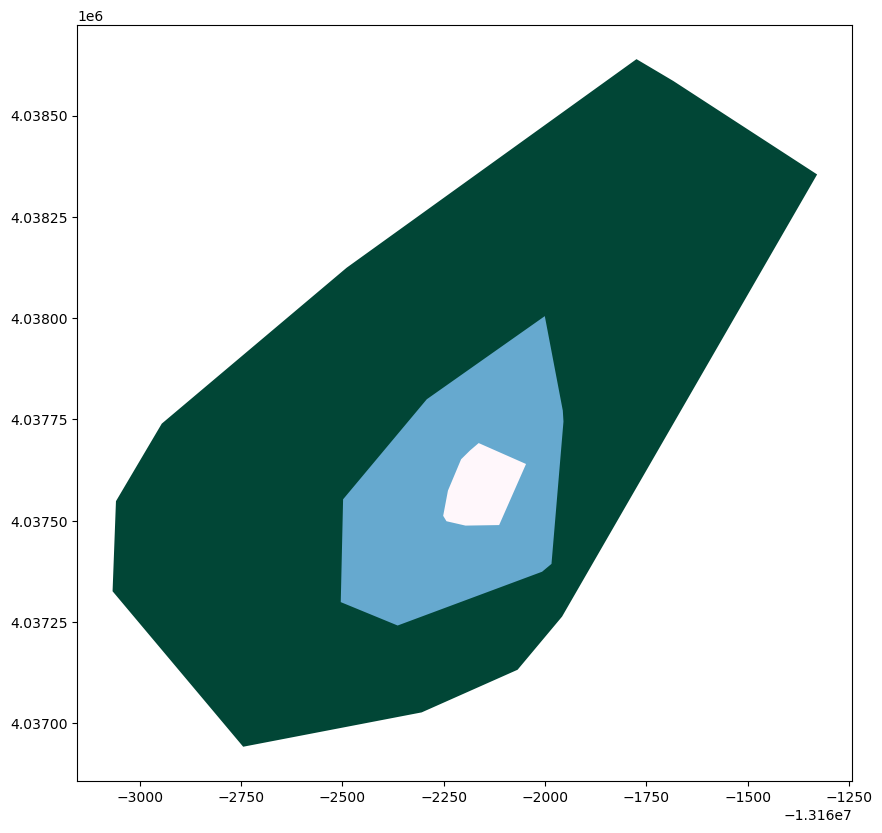

In [53]:
isochrones.plot(figsize=(10,10),alpha=1,color=iso_colors, legend=True)

### The pretty isochrones map

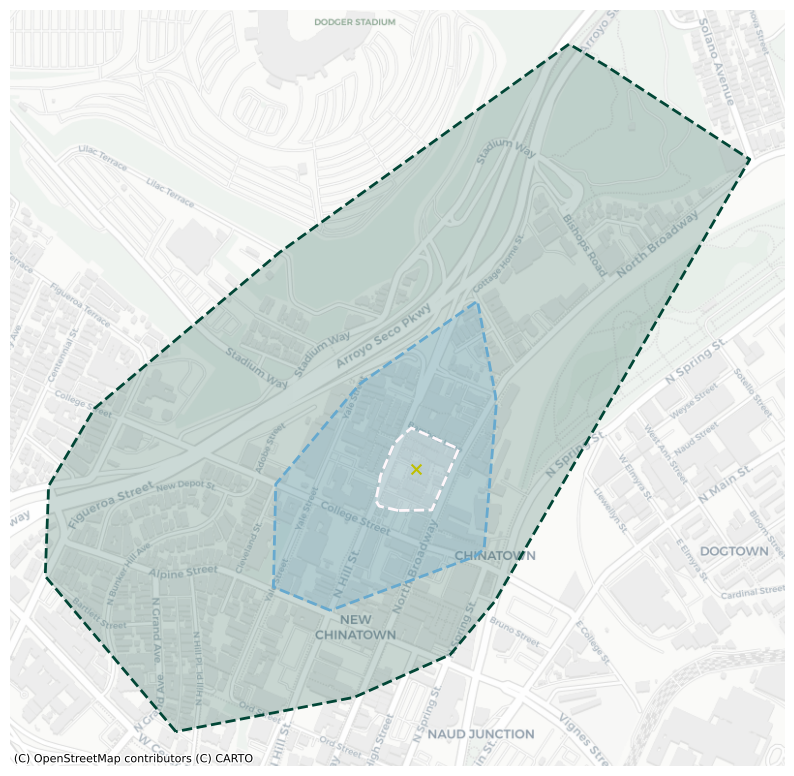

In [56]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True,
    color=iso_colors,
    )

# add the center node in yellow
gdf_nodes.loc[[center_node]].plot(ax=ax,color='y',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now I will add a legend.

In [57]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

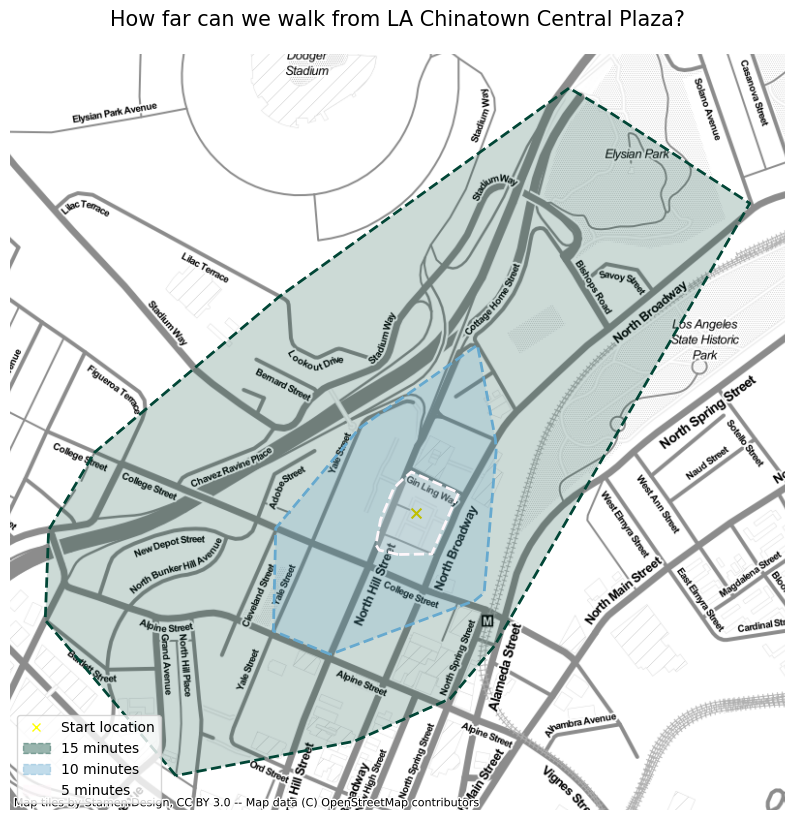

In [59]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, 
    color=iso_colors,
    )

# add the center node in yellow
gdf_nodes.loc[[center_node]].plot(
    ax=ax,
    color='y',
    marker='x',
    markersize=50
    )

# build custom legend
legend_elements = [
    # add the center node to the legend
    Line2D([0], [0], marker='x', color='yellow', linestyle='',label='Start location', markersize=6),
    ]

# sort back to small time to large time
time_color.reverse()

# loop through the list of time/colors and add each to the legend
for time,color in list(time_color):
    legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--',linewidth=1,label=str(time)+' minutes',alpha=0.4)
    legend_elements.append(legend_item)

# add the legend
ax.legend(handles=legend_elements,loc='lower left')

# add a title
ax.set_title('How far can we walk from LA Chinatown Central Plaza?',fontsize=15,pad=20)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

## Bringing in the previous map we made

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

We have done this before. We are creating the residential unit density map only for 2021. 

In [62]:
parcel_dataframe_residential = []

year=2021
parcel_data_filepath1 = "Assessor_Parcels_Data_" + str(year) + "_TRA.geojson"
parcel_df = gpd.read_file(parcel_data_filepath1)

columns_to_keep = ['UseType','YearBuilt','Units','geometry'] # define columns to keep
parcel_residential = parcel_df[columns_to_keep].copy() # define the columns to keep for the residential type
parcel_residential = parcel_residential[parcel_df.UseType == 'Residential']
parcel_residential['Year'] = year
parcel_dataframe_residential.append(parcel_residential) 
    
print(parcel_dataframe_residential[0].info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 612 entries, 1 to 1205
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   UseType    612 non-null    object  
 1   YearBuilt  612 non-null    int64   
 2   Units      612 non-null    int64   
 3   geometry   612 non-null    geometry
 4   Year       612 non-null    int64   
dtypes: geometry(1), int64(3), object(1)
memory usage: 28.7+ KB
None


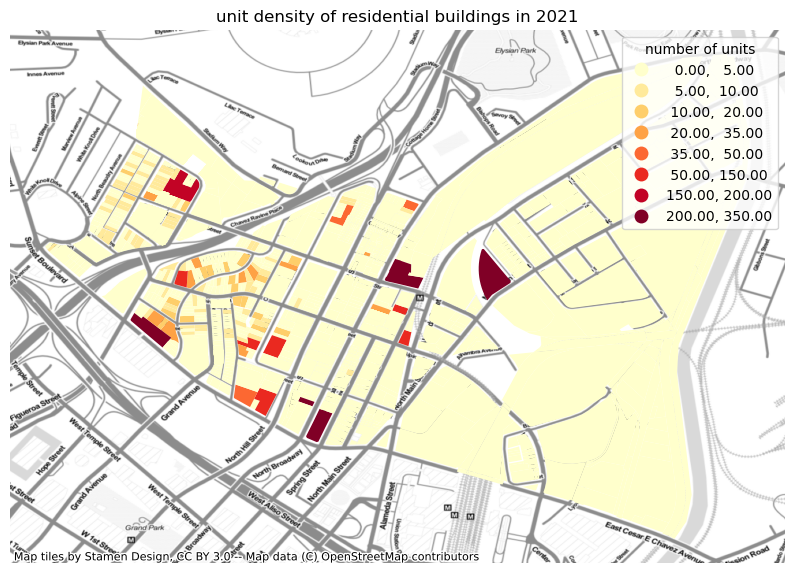

In [63]:
 fig, ax = plt.subplots(figsize=(10,10))
parcel_df.plot(ax=ax,
                column='Units',cmap='YlOrRd',
                legend=True, 
                scheme='userdefined',
                         legend_kwds={'title': "number of units", 'loc': 0,},
                        classification_kwds=dict(bins=[5,10,20,35,50,150,200,350]))
ax.set_title('unit density of residential buildings in 2021')
ax.axis('off')
    
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite,crs=4326)

## Layering the two maps together

First I will make sure that the CRS of the two maps are the same so that they allign.

In [64]:
parcel_df = parcel_df.to_crs(isochrones.crs)

Now we will just put the two layers together and create the final map.

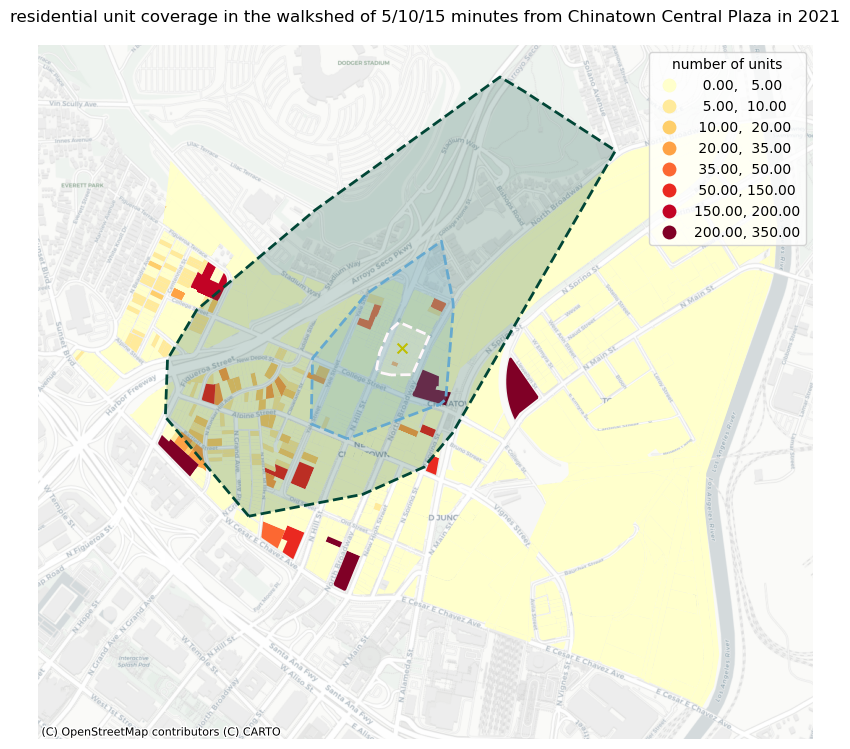

In [68]:
 fig, ax = plt.subplots(figsize=(10,10))
base = parcel_df.plot(ax=ax,
                column='Units',cmap='YlOrRd',
                legend=True, 
                scheme='userdefined',
                         legend_kwds={'title': "number of units", 'loc': 0,},
                        classification_kwds=dict(bins=[5,10,20,35,50,150,200,350]))
ax.set_title('residential unit coverage in the walkshed of 5/10/15 minutes from Chinatown Central Plaza in 2021')
ax.axis('off')

# add the isochrone boundary
isochrones.boundary.plot(
    ax=base,
    alpha=1,
    linestyle='--',
    color=iso_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=base, 
    alpha=0.2, 
    categorical=True, 
    color=iso_colors,
    )

# add the center node in yellow
gdf_nodes.loc[[center_node]].plot(
    ax=ax,
    color='y',
    marker='x',
    markersize=50
    )

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Interpretation and Conclusion

From the above map, we can see that most multi-family unit buildings, expeciall those fewer than 50 units, fall into the 15-minute walkshed from the LA Chinatown Central Plaza.

For the map itself, I tried to create two legends, but the latter one always overwrites the previous one, so I keep the unit density index. 

In terms of the content, it is true that within the 5-minute walkshed of the central plaza, there is few multi-family units. A very interesting point is that there is quite an area of 0-5 unit residential builidngs that is not covered within the 15-minute walkshed. It indicates that this area is both far away from this traditional commercial center, and that this area is not a hub for recent multi-family unit building development. For the one 'over 200‘ residential building that falls within the 10-minute walkshed, we might want to figure out its development, future investment status.

If talking the 15-minute city concept into account, we might also want to find out whether the southwest concentration of multi-family unit is also shaped by the new urban policies like 'pedestrian-friendly neighborhood', and whether these are the areas where gentrification mainly takes place. Briefly, this assignment shapes the direction and the next step for our research.